<a href="https://colab.research.google.com/github/tabaraei/Data-Science-Toolkit/blob/master/Scikit-Learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup the enivironment

Please ensure that you have the latest scikit-learn version.
Run `!pip install --upgrade scikit-learn` if necessary.

In [ ]:
# restart runtime after running the following command
!pip install --upgrade scikit-learn

In [ ]:
import pandas as pd
import numpy as np

## Data configuration

### 1- Load the dataset

#### 1-1- Regression data:

In [ ]:
from sklearn.datasets import load_diabetes

reg_dataframe = load_diabetes(as_frame=True).frame
reg_dataframe.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


#### 1-2- Classification data

In [ ]:
from sklearn.datasets import fetch_openml

cls_dataframe = fetch_openml(name='adult', version=2, as_frame=True).frame
cls_dataframe.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K


### 2- Handling missing values

#### 2-1- Remove rows with missing value

In [ ]:
print(reg_dataframe.shape, cls_dataframe.shape)
reg_dataframe.dropna(axis=0, inplace=True)
cls_dataframe.dropna(axis=0, inplace=True)
print(reg_dataframe.shape, cls_dataframe.shape)

(442, 11) (48842, 15)
(442, 11) (45222, 15)


#### 2-2- Remove cols with missing value

In [ ]:
reg_cols_with_missing = [col for col in reg_dataframe.columns if reg_dataframe[col].isnull().any()]
reg_dataframe.drop(reg_cols_with_missing, axis=1, inplace=True)

cls_cols_with_missing = [col for col in cls_dataframe.columns if cls_dataframe[col].isnull().any()]
cls_dataframe.drop(cls_cols_with_missing, axis=1, inplace=True)

reg_cols_with_missing, cls_cols_with_missing

([], [])

### 3- Train Test Split

#### 3-1- Split target class from features

In [ ]:
y_reg = reg_dataframe['target']
X_reg = reg_dataframe.drop(['target'], axis='columns')

y_cls = cls_dataframe['class']
X_cls = cls_dataframe.drop(['class'], axis='columns')

#### 3-2- Split training data from test data

In [ ]:
from sklearn.model_selection import train_test_split

X_train_reg, X_test_reg, y_train_reg, y_test_reg = \
    train_test_split(X_reg, y_reg, random_state=1, test_size=0.1)

X_train_cls, X_test_cls, y_train_cls, y_test_cls = \
    train_test_split(X_cls, y_cls, random_state=1, test_size=0.1)

#### 3-3- Prevent from SettingWithCopyWarning

In [ ]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = \
    X_train_reg.copy(), X_test_reg.copy(), y_train_reg.copy(), y_test_reg.copy()

X_train_cls, X_test_cls, y_train_cls, y_test_cls = \
    X_train_cls.copy(), X_test_cls.copy(), y_train_cls.copy(), y_test_cls.copy()

## Preprocessing

### 1- Handling categorical features

In [ ]:
categories = X_train_cls.select_dtypes(include='category')
low_cardinality_cols = [col for col in X_train_cls.columns if X_train_cls[col].nunique() < 7]
high_cardinality_cols = list(set(categories) - set(low_cardinality_cols))

low_cardinality_cols, high_cardinality_cols

(['relationship', 'race', 'sex'],
 ['workclass', 'education', 'marital-status', 'native-country', 'occupation'])

#### 1-1- Ordinal Encoder

In [ ]:
X_train_cls[high_cardinality_cols].head(3)

,workclass,education,marital-status,native-country,occupation
917,Private,Some-college,Married-civ-spouse,United-States,Machine-op-inspct
28178,Private,Some-college,Married-civ-spouse,United-States,Sales
46975,Private,HS-grad,Married-civ-spouse,United-States,Handlers-cleaners


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
X_train_cls[high_cardinality_cols] = encoder.fit_transform(X_train_cls[high_cardinality_cols].copy())
X_test_cls[high_cardinality_cols] = encoder.transform(X_test_cls[high_cardinality_cols].copy())

In [ ]:
X_train_cls[high_cardinality_cols].head(3)

,workclass,education,marital-status,native-country,occupation
917,2.0,15.0,2.0,38.0,6.0
28178,2.0,15.0,2.0,38.0,11.0
46975,2.0,11.0,2.0,38.0,5.0


#### 1-2- One Hot Encoder

In [ ]:
X_train_cls[low_cardinality_cols].head(3)

,relationship,race,sex
917,Husband,White,Male
28178,Husband,White,Male
46975,Husband,White,Male


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# get dataframe of one-hot encoding on low cardinality columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
one_hot_train = pd.DataFrame(encoder.fit_transform(X_train_cls[low_cardinality_cols]))
one_hot_test = pd.DataFrame(encoder.transform(X_test_cls[low_cardinality_cols]))

# fix indices of one-hot encoder before merging
one_hot_train.index = X_train_cls.index
one_hot_test.index = X_test_cls.index

# assign column names
one_hot_train.columns = encoder.get_feature_names()
one_hot_test.columns = encoder.get_feature_names()

# Remove categorical columns
X_train_cls = X_train_cls.drop(low_cardinality_cols, axis=1)
X_test_cls = X_test_cls.drop(low_cardinality_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train_cls = pd.concat([X_train_cls, one_hot_train], axis=1)
X_test_cls = pd.concat([X_test_cls, one_hot_test], axis=1)

In [ ]:
one_hot_train.head(3)

,x0_Husband,x0_Not-in-family,x0_Other-relative,x0_Own-child,x0_Unmarried,x0_Wife,x1_Amer-Indian-Eskimo,x1_Asian-Pac-Islander,x1_Black,x1_Other,x1_White,x2_Female,x2_Male
917,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
28178,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
46975,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


#### 1-3- Remove Categorical features and replace with preprocessed ones

### 2- Numeric features

Using [drawdata](https://drawdata.xyz/) website, you can easily draw points on the flow, and download the corresponding `csv` file to play with.

#### Scaling

In order to normalize the numerical columns, there are various strategies to be utilized:
- `StandardScaler`, which standardizes features by forcing zero mean and scaling to unit variance as `z = (x - u) / s`.
- `QuantileTransformer`, which is less affected by the outliers and better transforms the data based on quantiles.
- TO BE ADDED: PolynomialFeatures()

In [ ]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

# variants of scaler can be easily substituted, such as "QuantileTransformer"
scaler = StandardScaler()
X, _ = load_wine(return_X_y=True)
X_scaled = scaler.fit_transform(X)

#### Imputer (missing values)

Transformers for missing value imputation can be found [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute). Such as:
- `SimpleImputer`, _univariate_ imputer for completing missing values with simple strategies. Replaces missing values using a descriptive statistic (e.g. mean, median, or most frequent) along each column, or using a constant value.
- `IterativeImputer`, _multivariate_ imputer that estimates each feature from all the others.
- `MissingIndicator`, binary indicators for missing values.
- `KNNImputer`, imputation for completing missing values using k-Nearest Neighbors. Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set (two samples are close if the features that neither is missing are close).

In [ ]:
from sklearn.datasets import load_wine
from sklearn.impute import SimpleImputer, KNNImputer

imputer = SimpleImputer()
X, _ = load_wine(return_X_y=True)
X_scaled = imputer.fit_transform(X)

## Model Training

### Baseline Models

Basically, in model prediction, we assume that we have a dataset divided into two subsets:
- `X` is our feature set, which can contain categorical, numerical, boolean, and any type of value used in prediction
- `y` is our target set, which defines the desired predicted values

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y=True)
load_diabetes(as_frame=True).frame.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0


We should also consider splitting these sets into _training_ and _test_ sets, in order to divide the evaluation phase from our learning phase.
There are several strategies to achieve this as defined [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection), and also a nice visualization of these methods can be seen [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py). Here, we will stick to the common `train_test_split` function:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Then, we need to create our _model object_, which can be chosen among a variety of methods for the selected task. Since the internal API of all these objects is the same, we simply train the model by `X_train` and `y_train` using `.fit(X_train, y_train)`, and we further use the model object for predictions on the _test dataset_ using `.predict(X_test)`.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

# model can be simply substituted with another model, such as "LinearRegression"
model = KNeighborsRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model

KNeighborsRegressor()

If the model is not shown as a diagram above, consider activating the diagram display to see the visualized model.

In [ ]:
from sklearn import set_config

set_config(display='diagram')

### Pipeline

Sometimes, the prediction can be skewed in favour of some axes if our features in `X` are not normalized and they lie toward the widest range of values. It will force feature space vector along one direction, and it is necessary to follow some normalization steps to avoid this situation. In these cases, we want to expand the idea of _Model_ to a _Pipeline_ where everything inside this box is considered as the model. This notion also allows our test set to have the same preprocessing steps, and we can easily use the `.fit` and `.predict` to train our model in the pipeline. Pipeline, is a **list of tuples**, where each tuple defines the step taken in the `('name', object)` format .

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('model', KNeighborsRegressor())
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
pipe

Pipeline(steps=[('scaling', StandardScaler()),
                ('model', KNeighborsRegressor())])

### GridSearchCV

For each model, we might have to set several hyperparameters such that they best fit our data. It might be a time-consuming task to manually set and try different combinations of these parameters to find the best match. Using `GridSearchCV`, we perform a search on the defined values for our hyperparameters, while applying internal cross-validation at the same time. This method can be used with `.fit` and `.predict` as well.
The `estimator` attribute expects a model or pipeline, and the `param_grid` attribute expects a dictionary of all the desired params to be checked according to the define values. Note that we apply this on the original `X` and `y`, since it automatically applies cross-validation. There are also another hyperparameter optimizers defined [here](https://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers).

In [ ]:
pipe.get_params()

{'memory': None,
 'steps': [('scaling', StandardScaler()), ('model', KNeighborsRegressor())],
 'verbose': False,
 'scaling': StandardScaler(),
 'model': KNeighborsRegressor(),
 'scaling__copy': True,
 'scaling__with_mean': True,
 'scaling__with_std': True,
 'model__algorithm': 'auto',
 'model__leaf_size': 30,
 'model__metric': 'minkowski',
 'model__metric_params': None,
 'model__n_jobs': None,
 'model__n_neighbors': 5,
 'model__p': 2,
 'model__weights': 'uniform'}

In [ ]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

grid = GridSearchCV(
    estimator=pipe,
    param_grid={'model__n_neighbors': range(1,5)},
    cv=3
)
grid.fit(X, y)
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004440,0.002448,0.005789,0.003455,1,{'model__n_neighbors': 1},0.105976,0.124092,-0.158523,0.023849,0.129168,4
1,0.002546,0.000058,0.003248,0.000104,2,{'model__n_neighbors': 2},0.268889,0.339379,0.264563,0.290944,0.034295,3
2,0.002581,0.000090,0.003354,0.000182,3,{'model__n_neighbors': 3},0.333057,0.382744,0.356899,0.357567,0.020290,2
3,0.004172,0.002058,0.006057,0.003243,4,{'model__n_neighbors': 4},0.342407,0.404701,0.409910,0.385673,0.030668,1


### Evaluation

Whether we are using `GridSearchCV` or any other strategy to find the best combination of hyperparameters along with the proper model selection regarding our task, we will evaluate and compare the different models based on a _metric_. A variety of metrics are predefined [here](https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).

#### Classification

There are different metrics to measure the classification results, such as:
- `accuracy_score`: Whether the _predicted_ labels exactly match the _true_ labels.
- `recall_score`: The ability of the classifier to find _all the positive samples_ (`TP / (TP + FN)`).
- `precision_score`: The ability of the classifier _not to label as positive_ for a sample that is negative (`TP / (TP + FP)`).


In [55]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score

X, y = load_breast_cancer(return_X_y=True)
model = LogisticRegression(max_iter=3000).fit(X, y)
y_pred = model.predict(X)

# note that the metrics are applied to the training data, not the test data
accuracy_score(y, y_pred), recall_score(y, y_pred), precision_score(y, y_pred)

(0.9578207381370826, 0.9747899159663865, 0.9586776859504132)

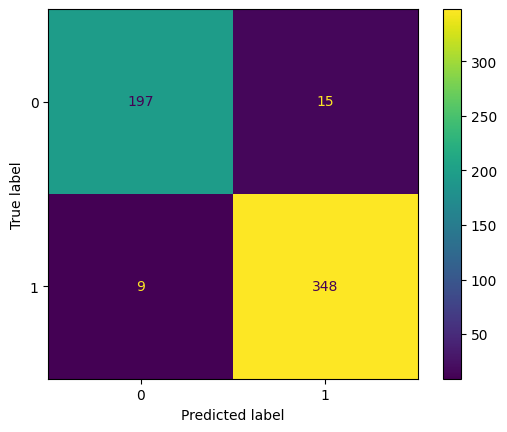

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot();

We have scenarios where making mistakes during the prediction toward either false positive (FP) or false negative (FN) might influence the performance of our model. For example, in case of cancer prediction or fraud detection, we might have imbalanced datasets that require higher weight associated with the positive classes, because there are fewer cases with a `True` value and they denote a more sensitive group. In such scenarios, we would prefer optimizing the __recall__ measure rather than other metrics.

The following cell represents a hyperparameter optimization such as `GridSearchCV`, where we assign a higher weight ratio to the positive class using `class_weight` parameter, as well as defining our own new metric to be calculated:

In [38]:
def min_recall_precision(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import pandas as pd
import numpy as np

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=5000),
    param_grid={'class_weight': [{0:1, 1:w} for w in np.linspace(1, 20, 30)]},
    scoring={
        'recall': make_scorer(recall_score),
        'precision': make_scorer(precision_score),
        'min_both': make_scorer(min_recall_precision)
    },
    refit='min_both', # scorer used to find the best params refitting the model
    return_train_score=True,
    cv=5,
    n_jobs=-1
)
grid.fit(X, y)
# y_pred = grid.best_estimator_.predict(X)

metrics_df = pd.DataFrame(grid.cv_results_)
metrics_df.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,...,mean_test_min_both,std_test_min_both,rank_test_min_both,split0_train_min_both,split1_train_min_both,split2_train_min_both,split3_train_min_both,split4_train_min_both,mean_train_min_both,std_train_min_both
0,0.005606,0.001035,0.007405,0.002388,"{0: 1, 1: 1.0}","{'class_weight': {0: 1, 1: 1.0}}",0.9,0.9,0.8,0.7,...,0.765734,0.092200,14,0.92500,0.950000,0.951220,0.951220,0.875000,0.930488,0.029494
1,0.005325,0.000754,0.006674,0.000094,"{0: 1, 1: 1.6551724137931034}","{'class_weight': {0: 1, 1: 1.6551724137931034}}",1.0,0.9,0.9,0.8,...,0.770303,0.091079,13,0.97561,0.951220,0.930233,0.952381,0.952381,0.952365,0.014363
2,0.005558,0.000328,0.007438,0.001462,"{0: 1, 1: 2.310344827586207}","{'class_weight': {0: 1, 1: 2.310344827586207}}",1.0,0.9,0.9,0.8,...,0.790303,0.105277,1,0.97561,0.928571,0.909091,0.930233,0.930233,0.934747,0.021940


The plot below is able to show the effect of hyperparameter exploration on the `class_weight` parameter defined in our search, where for different values ranging within `np.linspace(1, 20, 30)` we can see their according effect on the metrics defined.

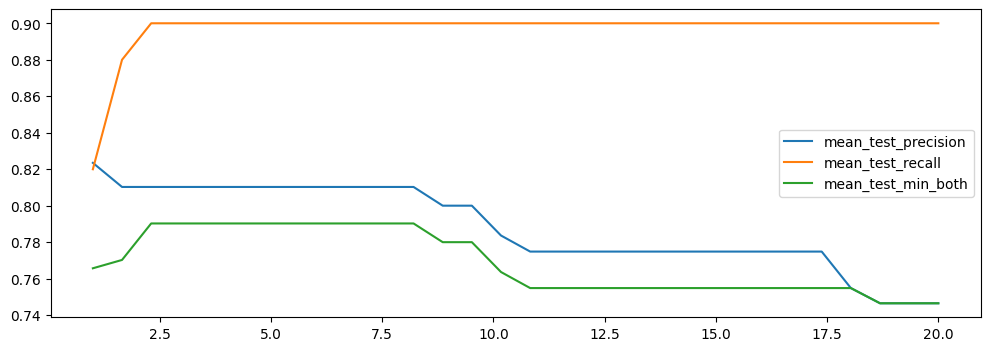

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for score in ['mean_test_precision', 'mean_test_recall', 'mean_test_min_both']:
    plt.plot([_[1] for _ in metrics_df['param_class_weight']], metrics_df[score], label=score)
plt.legend();

#### Regression

Using a rather simple scatter plot, we can see if there is a positive correlation between the predicted values and the desired values:

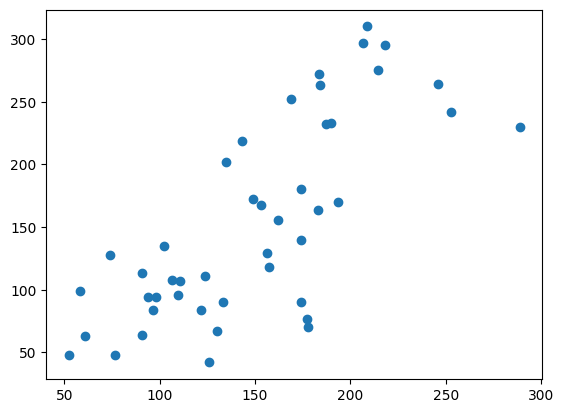

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_pred, y_test)

### 1- Regression

#### 1-1- Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

X, y = X_train_reg, y_train_reg
clf = LinearRegression()
clf.fit(X, y)

LinearRegression()

#### 1-2- Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

X, y = X_train_reg, y_train_reg
clf = LogisticRegression(random_state=0, max_iter=1000)
clf.fit(X, y)

LogisticRegression(max_iter=1000, random_state=0)

#### 1-3- Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X, y = X_train_reg, y_train_reg
clf = RandomForestRegressor(n_estimators=100, random_state=0)
clf.fit(X, y)

RandomForestRegressor(random_state=0)

#### 1-3- XGBoost Regressor

In [ ]:
from xgboost import XGBRegressor

X, y = X_train_reg, y_train_reg
clf = XGBRegressor(n_estimators=500, learning_rate=0.05, n_jobs=4, random_state=0)
clf.fit(X, y, early_stopping_rounds=5,
             eval_set=[(X_test_reg, y_test_reg)],
             verbose=False)

[16:02:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.05, n_estimators=500, n_jobs=4)

### 2- Classification

#### 2-1- Desicion Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

X, y = X_train_cls.select_dtypes(exclude='category'), y_train_cls
clf = DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier()

### 3- Model features

In [ ]:
clf.__class__.__name__

'DecisionTreeClassifier'

## Evaluation

Predict and evaluate model performance on a model. See a list of metrics [here](https://scikit-learn.org/stable/modules/model_evaluation.html).

### 1- Regression

In [ ]:
X, y, X_test, y_test = X_train_reg, y_train_reg, X_test_reg, y_test_reg
clf = LinearRegression()
clf.fit(X, y)

LinearRegression()

In [ ]:
y_pred = clf.predict(X_test)
y_pred[:5]

array([122.41932407, 111.48365055, 184.18558652,  68.52087272,
       171.44221745])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

MAE = mean_absolute_error(y_test, y_pred).round()
MSE = mean_squared_error(y_test, y_pred).round()

MAE, MSE

(43.0, 3320.0)

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_absolute_error') * -1

array([40.93764884, 48.2289054 , 46.57700111, 45.73373047, 43.7460327 ])

### 2- Classification

In [ ]:
X, y, X_test, y_test = X_train_cls, y_train_cls, X_test_cls, y_test_cls
clf = DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier()

In [ ]:
y_pred = clf.predict(X_test)
y_pred[:5]

array(['<=50K', '<=50K', '<=50K', '<=50K', '<=50K'], dtype=object)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(y_test, y_pred).round(3)  # or: clf.score(X_test, y_test)
precision = precision_score(y_test, y_pred, pos_label='>50K').round(3)
recall = recall_score(y_test, y_pred, pos_label='>50K').round(3)

accuracy, precision, recall

(0.801, 0.592, 0.633)

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(DecisionTreeClassifier(), X, y, cv=5, scoring='accuracy')

array([0.81044226, 0.81056511, 0.80614251, 0.80896806, 0.81091043])

## Pipeline

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# define columns
numerical_cols = X_cls.select_dtypes(exclude='category').columns.tolist()
categorical_cols = list(set(X_cls.columns)-set(numerical_cols))

# train test split
X, X_test, y, y_test = train_test_split(X_cls, y_cls, random_state=0, test_size=0.2)

In [ ]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('Numerical', numerical_transformer, numerical_cols),
        ('Categorical', categorical_transformer, categorical_cols)
    ])

# Define model
model = DecisionTreeClassifier()

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Cross validation scores
cross_val_score(clf, X, y, cv=5, scoring='accuracy')

array([0.80085683, 0.81329464, 0.81617139, 0.80939876, 0.81630961])

In [ ]:
# Preprocessing of training data, fit model
clf.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical',
                                                  SimpleImputer(strategy='median'),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('Categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'education',
                                                   'race', 'marital-status',
                                                   'relationship',
                                                   'native-country',
                                                   'occupation', 'sex'])])),
                ('model', DecisionTreeClassifier())])

In [ ]:
# Preprocessing of validation data, get predictions
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred).round(3)

0.805